# This code use the extracted features to train and test Siesemic architecture

## Uses (X_100.npy, y_100.npy) --> X_100.npy contains nearly 1200 touch events per user for all 100 users. y_100.npy contains user labels

##  writing and sitting (X_100_W_S.npy, y_100_W_S.npy')

## writing and walking (X_100_W_W.npy, y_100_W_W.npy)

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from trainer import fit
import pickle
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
from losses import ContrastiveLoss

# reading and sitting
X = np.load('X_100.npy')
y = np.load('y_100.npy')

# writing and sitting
# X = np.load('X_100_W_S.npy')
# y = np.load('y_100_W_S.npy')

# # writing and walking
# X = np.load('X_100_W_W.npy')
# y = np.load('y_100_W_W.npy')

# Step 1: Convert pandas DataFrames to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)  # Assuming y contains integer labels

X /=np.linalg.norm(X, axis=1, keepdims=True)

## This fucntion perform touch event aggregation

## Currently it aggregates 20 touches and generate 300 ATEs

In [ ]:
import torch

def create_XX(X, y, num_samples_per_iteration=10, num_iterations=300):
  # Get unique labels
  unique_labels = np.unique(y)

  # Initialize XX as an empty tensor to store all means
  XX = torch.empty((unique_labels.shape[0], num_iterations, X.shape[1]))

  # Loop through unique labels
  for i, label in enumerate(unique_labels):

    # Get indices of rows with current label
    label_indices = np.where(y == label)[0]

    # Check if there are enough rows for sampling
    if label_indices.shape[0] < num_samples_per_iteration:
        print(f"Warning: Label {label} has only {label_indices.shape[0]} rows. Sampling all available rows in each iteration.")

    # Loop for each iteration
    for j in range(num_iterations):
      if label_indices.shape[0] < num_samples_per_iteration:
          # Use all available rows if not enough for sampling
          selected_indices = label_indices
      else:
          # Randomly sample indices from rows with the same label
          selected_indices = torch.randint(0, label_indices.shape[0], (num_samples_per_iteration,))

      # Get the selected rows
      selected_rows = X[label_indices[selected_indices]]

      # Calculate mean of the selected rows
      mean_of_rows = torch.mean(selected_rows, dim=0)

      # Assign the mean to the corresponding row and iteration in XX
      XX[i, j] = mean_of_rows

  return XX

# Example usage
XX = create_XX(X, y, num_samples_per_iteration=20, num_iterations=300)
print(XX.shape)  # Should be (number of unique labels, number of iterations, number of features in X)


In [296]:
import torch

def reshape_by_label(X):
    labels = []
    
    num_labels, num_samples, num_features = X.shape

    X_reshaped = X.view(num_labels, -1, num_features)  # -1 infers the size based on other dims

    # Create an empty tensor to store data points from all labels
    data_by_label = torch.empty((0, num_features))

    # Loop through each label
    for label in range(num_labels):
    # Get data points for the current label
        current_label_data = X_reshaped[label]

        # Stack the data points vertically (concatenate rows)
        data_by_label = torch.vstack((data_by_label, current_label_data))


        labels.extend([label] * num_samples)


    # Convert labels list to a tensor
    labels_tensor = torch.tensor(labels)

    return data_by_label, labels_tensor


X, y = reshape_by_label(XX)
y = y.unsqueeze(1)

## Seperate the data for training and testing

## Currently it uses first 50 users for training and last 50 users for testing

In [297]:
train_mask = (y <= 50) & (y >= 0)
test_mask = (y > 50)

# Split X and y using boolean indexing
X_train = X[train_mask.any(dim=1)]
y_train = y[train_mask.any(dim=1)]
X_test = X[test_mask.any(dim=1)]
y_test = y[test_mask.any(dim=1)]

# Print the split data (should have the same dimensions as X and y)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: torch.Size([15300, 144])
y_train: torch.Size([15300, 1])
X_test: torch.Size([14700, 144])
y_test: torch.Size([14700, 1])


## This function creates triplet pairs.

## Each user, it creates 10 anchor and 10 positive pairs. For each anchor and positive pair, it assign 16 negative pairs. The best negative pait will be selected.

In [298]:
def customBatches(X,y, batches):
    batches_data = []
    for batch in range(0,batches):
        if batch % 10 ==0:
            print("batch: ",batch)
        index=0
        anchor_index_con = []
        positive_index_con = []
        negative_index_con = [[]]
        for label in np.unique(y):
#         for label in np.random.choice(np.unique(y), size=25, replace=False):
            num_pos = 10
            num_neg_per_pair = 16

            class_anc_ind = np.where(y == label)[0]
            class_pos_ind = np.where(y == label)[0]
            class_neg_ind = np.where(y != label)[0]

            anchor_index   = np.random.choice(class_anc_ind, size=num_pos, replace=False)
            positive_index = np.random.choice(class_pos_ind, size=num_pos, replace=False)
           
            negative_index = []  # Initialize an empty list
            for _ in range(num_neg_per_pair):  # Use a throwaway variable for clarity
                negative_index.append(np.random.choice(class_neg_ind, size=num_pos, replace=False))

            negative_index = np.array(negative_index).transpose()
        
            if index == 0:
                anchor_index_con   = anchor_index
                positive_index_con = positive_index
                negative_index_con = negative_index
            else:  
                anchor_index_con   = np.concatenate((anchor_index_con, anchor_index), axis=0)
                positive_index_con = np.concatenate((positive_index_con, positive_index), axis=0)
                negative_index_con = np.concatenate((negative_index_con, negative_index), axis=0)
            
            index +=1
        

        batch_data = {"anchor_index": X[anchor_index_con], 
                  "positive_index": X[positive_index_con], 
                  "negative_index": negative_index_con}
        batches_data.append(batch_data)
    
    return batches_data

In [299]:
## Assuming 'batch_size' and 'cuda' are defined
batches = 256

train_dataset = customBatches(X_train, y_train, batches)

batch:  0
batch:  10
batch:  20
batch:  30
batch:  40
batch:  50
batch:  60
batch:  70
batch:  80
batch:  90
batch:  100
batch:  110
batch:  120
batch:  130
batch:  140
batch:  150
batch:  160
batch:  170
batch:  180
batch:  190
batch:  200
batch:  210
batch:  220
batch:  230
batch:  240
batch:  250


In [300]:
batches = 128
test_dataset = customBatches(X_test, y_test, batches)

batch:  0
batch:  10
batch:  20
batch:  30
batch:  40
batch:  50
batch:  60
batch:  70
batch:  80
batch:  90
batch:  100
batch:  110
batch:  120


In [301]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContrastiveLossNew(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLossNew, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - target) * torch.pow(euclidean_distance, 2) +
                                      (target) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        
        distance_positive = (anchor - positive).pow(2).sum(1)  #.pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + 1.5)
        
            
        return losses.mean() if size_average else losses.sum()
    
class SiameseNet(nn.Module):
    def __init__(self, input_size, embedding_size, dropout_prob=0.0, weight_decay=0.0):
        super(SiameseNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 196),
            nn.ReLU(),
            nn.Linear(196, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
#             nn.Linear(96, 64),
#             nn.ReLU(),
            nn.Linear(64, embedding_size),
#             nn.Sigmoid()  # Adding ReLU
            nn.BatchNorm1d(embedding_size)  # Adding BatchNorm1d for normalization
        )

        # Adding L2 regularization to linear layers
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)  # Initialize weights with He initialization
                nn.init.zeros_(layer.bias)  # Initialize biases with zeros
                self.weight_decay = weight_decay

    def forward_once(self, x):
        x = self.fc(x)
        return x / torch.norm(x, p=2, dim=1, keepdim=True)  # Normalize the output to have unit norm

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

    

class SiameseNetCNN(nn.Module):
    def __init__(self, input_size, embedding_size, dropout_prob=0.0, weight_decay=0.0):
        super(SiameseNetCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 64),  # Adjusted input size
            nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 8),
#             nn.ReLU(),
            nn.Linear(64, embedding_size),
            nn.ReLU(),
            nn.BatchNorm1d(embedding_size)
        )

        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
                self.weight_decay = weight_decay

    def forward_once(self, x):
        x = x.view(x.shape[0], 1, 12, 12)
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.fc(x)
        return x / torch.norm(x, p=2, dim=1, keepdim=True)

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

In [302]:
def getBatch(anchor, positive, nagative_label,margin):
    outputs1, outputs2_positive = siamese_net(anchor, positive)
    d_pos = nn.functional.pairwise_distance(outputs1, outputs2_positive)
    
#     print(nagative_label)
    num_cols = nagative_label.shape[1]

    for col in range(num_cols):
        random_col = torch.randint(0, num_cols, size=(1,)).item()
        
        negative = X_train[nagative_label[:,random_col]]
        outputs1, outputs2_negative = siamese_net(anchor, negative)
        d_neg = nn.functional.pairwise_distance(outputs1, outputs2_negative)
        
        condition = (d_pos < d_neg) & (d_neg < d_pos + margin)
        result = torch.zeros_like(d_pos)  # Create a tensor of zeros with the same shape as d_pos
        result.scatter_(0, condition.nonzero().squeeze(), 1)  # Set corresponding elements to 1
        
        if col ==0:
            neg_labels = torch.from_numpy (nagative_label[:,random_col] ) * result
        else:
            A = neg_labels
            B = torch.from_numpy (nagative_label[:,random_col] ) * result
            # Find indices where A is zero and B is non-zero
            mask = (A == 0) & (B != 0)  # Element-wise AND for both conditions
            # Update A using indexing and B
            A[mask] = B[mask]
            
            neg_labels = A
        
        if torch.count_nonzero(neg_labels) == nagative_label.shape[0]:
#             print("I am breaking at col ", col)
            break
    
    return neg_labels
        

In [303]:
def save_model(model, filename):
    """Saves the PyTorch model to a file."""
    torch.save(model.state_dict(), filename)

Epoch [1/200], Loss: 0.15323481147061102
Epoch [6/200], Loss: 0.07257847375876736
Epoch [11/200], Loss: 0.05561589530407218
Epoch [16/200], Loss: 0.053785434749443084
Epoch [21/200], Loss: 0.05360440530057531
Epoch [26/200], Loss: 0.05318596178403823
Epoch [31/200], Loss: 0.05286471508588875
Epoch [36/200], Loss: 0.05281824979465455
Epoch [41/200], Loss: 0.052434436736803036
Epoch [46/200], Loss: 0.05283571366453543
Epoch [51/200], Loss: 0.05257118535519112
Epoch [56/200], Loss: 0.05307576722407248
Epoch [61/200], Loss: 0.05245847121113911
Epoch [66/200], Loss: 0.05283055920881452
Epoch [71/200], Loss: 0.05247776767646428
Epoch [76/200], Loss: 0.05204550469352398
Epoch [81/200], Loss: 0.05348961046547629
Epoch [86/200], Loss: 0.053217761873384006
Epoch [91/200], Loss: 0.05289735223050229
Epoch [96/200], Loss: 0.05294101567415055
Epoch [101/200], Loss: 0.052578582835849375
Epoch [106/200], Loss: 0.052005618206749205
Epoch [111/200], Loss: 0.05267674183414783
Epoch [116/200], Loss: 0.052

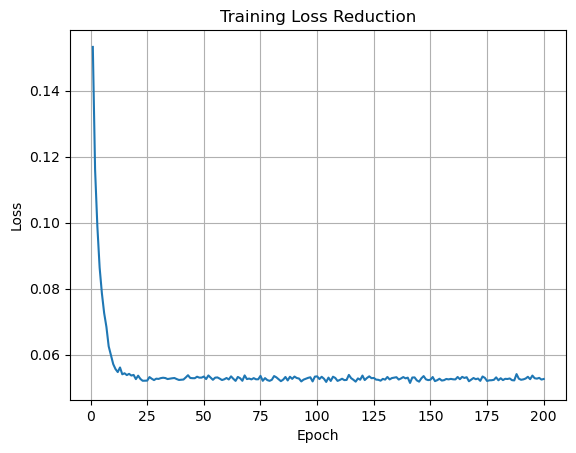

In [304]:
import numpy as np
import matplotlib.pyplot as plt

previous_loss = np.inf  # Initialize previous loss to a very high value
losses = []  # List to store loss values for each epoch

input_size = 144  # Assuming input data has dimensionality 784
embedding_size = 32  # Define the desired dimensionality of the output embedding
siamese_net = SiameseNet(input_size, embedding_size)
# siamese_net.load_state_dict(torch.load("siamese_model.pt"))  # Load saved state
margin = 32
num_epochs = 200

# criterion = ContrastiveLossNew(margin)
criterion = TripletLoss(margin)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataset, 0):
        siamese_net.eval()
        
#         filtered_anchor = data['anchor_index']
#         filtered_positive = data['positive_index']
#         negative_label = data['negative_index']
#         negative = X_train[negative_label[:, 0]]
        

        neg_labels = getBatch(data['anchor_index'],data['positive_index'],data['negative_index'],margin)    
        anchor  = data['anchor_index']
        positive = data['positive_index']
        mask = neg_labels != 0
        filtered_anchor = anchor[mask]
        filtered_positive = positive[mask]
        filtered_neg_labels = neg_labels[mask]
        negative = X_train[filtered_neg_labels.numpy()]

        
        

        if negative.shape[0] > 16:
            siamese_net.train()
            optimizer.zero_grad()

            outputs1, outputs2_positive = siamese_net(filtered_anchor, filtered_positive)
            outputs1, outputs2_negative = siamese_net(filtered_anchor, negative)

            loss = criterion(outputs1, outputs2_positive, outputs2_negative)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    scheduler.step()
    current_loss = running_loss / len(train_dataset)
    if epoch % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {current_loss}")

    losses.append(current_loss)  # Store current loss for plotting

#     Check if the current loss is not reducing compared to the previous loss
    if np.abs(current_loss - previous_loss) < 0.0000000001:
        print("Loss is not reducing. Exiting training.")
        break
    else:
        previous_loss = current_loss

# Plot the losses
plt.plot(range(1, len(losses) + 1), losses)
plt.title('Training Loss Reduction')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [305]:
 save_model(siamese_net, "siamese_model_Write_Sitting.pt")  # Replace with your filename

## Ploting the ditribution on training triplets

In [ ]:
# threshold = 1
correct_pos = 0
correct_neg = 0
total_pos = 0
total_neg = 0

distances_positive_list = []
distances_negative_list = []


siamese_net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during evaluation
    for i, data in enumerate(train_dataset, 0):
    
        anchor  = data['anchor_index']
        positive = data['positive_index']
        negative_lable = data['negative_index']
        
        negative = X_train[negative_lable[:,0]]
        
        
        # Forward pass
        outputs1, outputs2_positive = siamese_net(anchor, positive)
        outputs1, outputs2_negative = siamese_net(anchor, negative)
        
    
        distances_positive = (outputs1 - outputs2_positive).pow(2).sum(1) 
        distances_negative =  (outputs1 - outputs2_negative).pow(2).sum(1) 
        
#         distances_positive = (outputs1 * outputs2_positive).sum(dim=1)  # Negative sign for direction
#         distances_negative = (outputs1 * outputs2_negative).sum(dim=1)
        
    

        # Apply threshold to determine similarity
        predictions_positive = (distances_positive < threshold).float()
        distances_positive_list.append(distances_positive)
        predictions_negative = (distances_negative > threshold).float()
        distances_negative_list.append(distances_negative)
        
        
        labels = torch.ones_like(predictions_positive)

        correct_positive = (predictions_positive ==  torch.ones_like(predictions_positive)).sum().item()
        correct_negative = (predictions_negative ==  torch.ones_like(predictions_positive)).sum().item()
        correct_pos += correct_positive
        correct_neg += correct_negative
        
        total_pos += len(predictions_positive)
        total_neg += len(predictions_negative)

TP = correct_pos
TN = correct_neg
FP = total_neg - TN
FN = total_pos - TP


false_positve_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
true_positve_rate = TP / (TP + FN) if (TP + FN) > 0 else 0

print("TP :", TP)
print("FN :", FN) 
print("FP :", FP)   
print("TN :", TN)
print("True Positve Rate = TP / (TP + FN):",true_positve_rate)
print("False Positve Rate = FP / (FP + TN):", false_positve_rate) 


# Convert lists to torch tensors
distances_positive_tensor = torch.cat(distances_positive_list)
distances_negative_tensor = torch.cat(distances_negative_list)

import matplotlib.pyplot as plt

# Plot histogram for positive distances
plt.hist(distances_positive_tensor.cpu().numpy(), bins=100, alpha=0.5, color='blue', label='Between Anchor and Positive Inputs')

# Plot histogram for negative distances
plt.hist(distances_negative_tensor.cpu().numpy(), bins=100, alpha=0.5, color='red', label='Between Anchor and Negative Inputs')

# Add labels and legend
plt.xlabel('Euclidean Distance', fontsize = 12)
plt.ylabel('Number of Pairs', fontsize = 12)
# plt.title('Training with 50 Users')
plt.legend(fontsize = 12)

# Add grid
plt.grid(True)

# Show plot
plt.show()


## Use the below to load different trained models

In [6]:
input_size = 144
embedding_size = 32
siamese_net = SiameseNet(input_size, embedding_size)
siamese_net.load_state_dict(torch.load("siamese_model_20.pt"))  # Load saved state

<All keys matched successfully>

# Ploting the distribution for unseen testing triplets

TP : 61408
FN : 1312
FP : 5114
TN : 57606
True Positve Rate = TP / (TP + FN): 0.9790816326530613
False Positve Rate = FP / (FP + TN): 0.08153698979591836


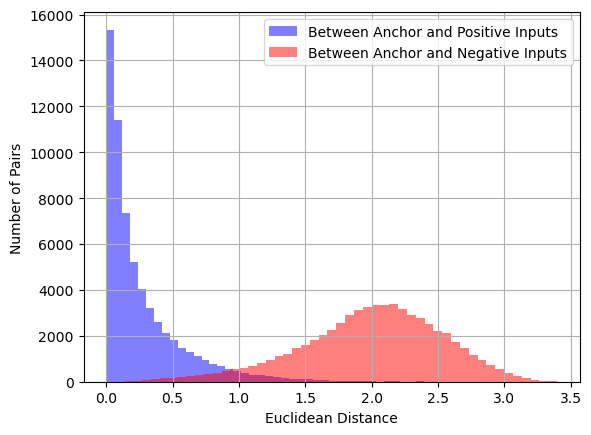

In [307]:
threshold = 1.2
correct_pos = 0
correct_neg = 0
total_pos = 0
total_neg = 0

distances_positive_list = []
distances_negative_list = []


siamese_net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during evaluation
    for i, data in enumerate(test_dataset, 0):
        
        anchor  = data['anchor_index']
        positive = data['positive_index']
        negative_lable = data['negative_index']
        
        negative = X_test[negative_lable[:,0]]
        
        
        # Forward pass
        outputs1, outputs2_positive = siamese_net(anchor, positive)
        outputs1, outputs2_negative = siamese_net(anchor, negative)
        
    
        distances_positive = (outputs1 - outputs2_positive).pow(2).sum(1) 
        distances_negative =  (outputs1 - outputs2_negative).pow(2).sum(1)  
        
#         distances_positive = (outputs1 * outputs2_positive).sum(dim=1)  # Negative sign for direction
#         distances_negative = (outputs1 * outputs2_negative).sum(dim=1)
    


        # Apply threshold to determine similarity
        predictions_positive = (distances_positive < threshold).float()
        distances_positive_list.append(distances_positive)
        predictions_negative = (distances_negative > threshold).float()
        distances_negative_list.append(distances_negative)
        
        
        labels = torch.ones_like(predictions_positive)

        correct_positive = (predictions_positive ==  torch.ones_like(predictions_positive)).sum().item()
        correct_negative = (predictions_negative ==  torch.ones_like(predictions_positive)).sum().item()
        correct_pos += correct_positive
        correct_neg += correct_negative
        
        total_pos += len(predictions_positive)
        total_neg += len(predictions_negative)

TP = correct_pos
TN = correct_neg
FP = total_neg - TN
FN = total_pos - TP


false_positve_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
true_positve_rate = TP / (TP + FN) if (TP + FN) > 0 else 0

print("TP :", TP)
print("FN :", FN) 
print("FP :", FP)   
print("TN :", TN)
print("True Positve Rate = TP / (TP + FN):",true_positve_rate)
print("False Positve Rate = FP / (FP + TN):", false_positve_rate) 


# Convert lists to torch tensors
distances_positive_tensor = torch.cat(distances_positive_list)
distances_negative_tensor = torch.cat(distances_negative_list)

import matplotlib.pyplot as plt

# Plot histogram for positive distances
plt.hist(distances_positive_tensor.cpu().numpy(), bins=50, alpha=0.5, color='blue', label='Between Anchor and Positive Inputs')

# Plot histogram for negative distances
plt.hist(distances_negative_tensor.cpu().numpy(), bins=50, alpha=0.5, color='red', label='Between Anchor and Negative Inputs')

# Add labels and legend
plt.xlabel('Euclidean Distance')
plt.ylabel('Number of Pairs')
# plt.title('Testing with 50 Users')
plt.legend()

# Add grid
plt.grid(True)

# Show plot
plt.show()

# The below code is miscelenious codes used to obtain various distributions

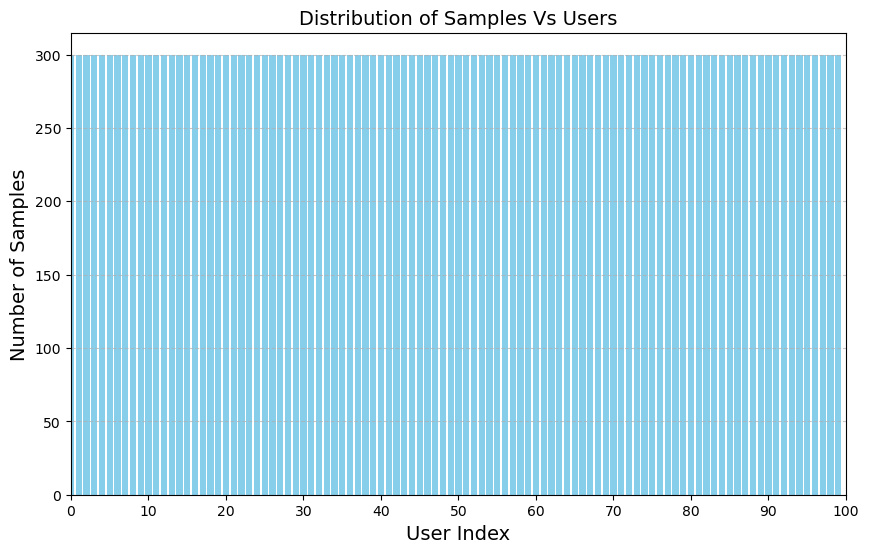

In [128]:
#Get the ditribtion of number of data points in the X_100.npy, y_100.npy
import numpy as np
import matplotlib.pyplot as plt

unique_labels, counts = np.unique(y, return_counts=True)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('User Index',fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.title('Distribution of Samples Vs Users', fontsize=14)

# Set x-axis ticks to print every 10 values
plt.xticks(np.arange(0, 101, 10))

# Limit the x-axis from 0 to 100
plt.xlim(0, 100)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [513]:
# This code generates embeddings using trained models

index = 50
test_mask = (y > index)

X_test = X[test_mask.any(dim=1)]
y_test = y[test_mask.any(dim=1)]

# Print the split data (should have the same dimensions as X and y)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

input_size = 144
embedding_size = 32
siamese_net = SiameseNet(input_size, embedding_size)
siamese_net.load_state_dict(torch.load("siamese_model_20.pt"))  # Load saved state

siamese_net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during evaluation
    outputs1, _ = siamese_net(X_test, X_test)

np.save('test_20_avg.npy', y_test-index-1)
np.save('test_embeddings_20_avg.npy', outputs1)

X_train: torch.Size([15300, 144])
y_train: torch.Size([15300, 1])
X_test: torch.Size([14700, 144])
y_test: torch.Size([14700, 1])


In [ ]:
y_test-index-1

In [ ]:
import numpy as np

X = np.load('X_10.npy')
y = np.load('y_10.npy')

# Step 1: Convert pandas DataFrames to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains integer labels

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.001, random_state=21)

X_train /=np.linalg.norm(X_train, axis=1, keepdims=True)
X_test /=np.linalg.norm(X_test, axis=1, keepdims=True)

In [ ]:
# Assuming 'batch_size' and 'cuda' are defined
batches = 100

test_dataset = customBatches(X_train, y_train, batches)

In [ ]:
threshold = 1.25
correct = 0
total=0

distances_positive_list = []
distances_negative_list = []


siamese_net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during evaluation
    correct = 0
    total = 0
    for i, data in enumerate(test_dataset, 0):
        
        anchor  = data['anchor_index']
        positive = data['positive_index']
        negative_lable = data['negative_index']
        
        negative = X_train[negative_lable[:,15]]
        
        
        # Forward pass
        outputs1, outputs2_positive = siamese_net(anchor, positive)
        outputs1, outputs2_negative = siamese_net(anchor, negative)
        
    
        # Calculate similarity score for positive pairs
        distances_positive = torch.pairwise_distance(outputs1, outputs2_positive)

        # Calculate similarity score for negative pairs
        distances_negative = torch.pairwise_distance(outputs1, outputs2_negative)

        # Apply threshold to determine similarity
        predictions_positive = (distances_positive < threshold).float()
        distances_positive_list.append(distances_positive)
        predictions_negative = (distances_negative > threshold).float()
        distances_negative_list.append(distances_negative)
        
        
        labels = torch.ones_like(predictions_positive)

        correct_positive = (predictions_positive ==  torch.ones_like(predictions_positive)).sum().item()
        correct_negative = (predictions_negative ==  torch.ones_like(predictions_positive)).sum().item()
        correct += correct_positive + correct_negative
        total += labels.size(0) * 2  # Each batch contains both positive and negative pairs


# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")
# Convert lists to torch tensors
distances_positive_tensor = torch.cat(distances_positive_list)
distances_negative_tensor = torch.cat(distances_negative_list)


import matplotlib.pyplot as plt

# Plot histogram for positive distances
plt.hist(distances_positive_tensor.cpu().numpy(), bins=50, alpha=0.5, color='blue', label='Positive Distances')

# Plot histogram for negative distances
plt.hist(distances_negative_tensor.cpu().numpy(), bins=50, alpha=0.5, color='red', label='Negative Distances')

# Add labels and legend
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances')
plt.legend()

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for positive distances
plt.hist(distances_positive_tensor.cpu().numpy(), bins=50, alpha=0.5, color='blue', label='Positive Distances')

# Plot histogram for negative distances
plt.hist(distances_negative_tensor.cpu().numpy(), bins=50, alpha=0.5, color='red', label='Negative Distances')

# Add labels and legend
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Distances')
plt.legend()

# Show plot
plt.show()

In [ ]:
threshold = 0.9
correct_pos = 0
correct_neg = 0
total_pos = 0
total_neg = 0

distances_positive_list = []
distances_negative_list = []


input_size = 144
embedding_size = 32
siamese_net = SiameseNet(input_size, embedding_size)
siamese_net.load_state_dict(torch.load("siamese_model_20.pt"))  # Load saved state

siamese_net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during evaluation
    for i, data in enumerate(train_dataset, 0):
        
        anchor  = data['anchor_index']
        positive = data['positive_index']
        negative_lable = data['negative_index']
        
        negative = X_train[negative_lable[:,2]]
        
        
        # Forward pass
        outputs1, outputs2_positive = siamese_net(anchor, positive)
        outputs1, outputs2_negative = siamese_net(anchor, negative)
        
        p = outputs1 - outputs2_positive
        n = outputs1 - outputs2_negative
        
        
        print(p.shape, n.shape)

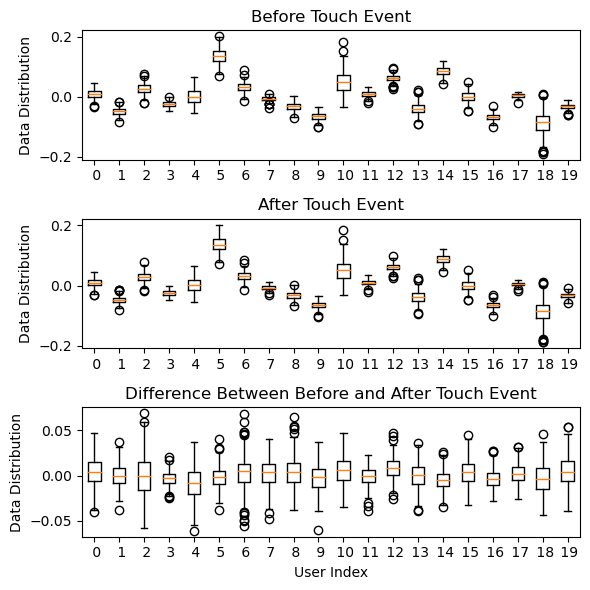

In [581]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X contains the data for several users and y contains the user labels
# Extract data for users 0, 1, 2, and 3
user_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
user_data = {user_idx: X[np.where(y == user_idx)[0]] for user_idx in user_indices}

# Create a subplot with 2 rows and 1 column
fig, axes = plt.subplots(3, 1, figsize=(6, 6))

# Plot box plot for column 6
axes[0].boxplot([user_data[user_idx][:, 0] for user_idx in user_indices], labels=[f' {user_idx}' for user_idx in user_indices])
axes[0].set_title('Before Touch Event')
# axes[0].set_xlabel('User Index')
axes[0].set_ylabel('Data Distribution')

# Plot box plot for column 7
axes[1].boxplot([user_data[user_idx][:, 16] for user_idx in user_indices], labels=[f' {user_idx}' for user_idx in user_indices])
axes[1].set_title('After Touch Event')
# axes[1].set_xlabel('User Index')
axes[1].set_ylabel('Data Distribution')

# Plot box plot for column 7
axes[2].boxplot([user_data[user_idx][:, 32] for user_idx in user_indices], labels=[f' {user_idx}' for user_idx in user_indices])
axes[2].set_title('Difference Between Before and After Touch Event')
axes[2].set_xlabel('User Index')
axes[2].set_ylabel('Data Distribution')

plt.tight_layout()
plt.show()

